From the last [blog post](https://wckdouglas.netlify.app/blog/experiment-with-jax/), I experimented with [JAX](https://github.com/google/jax). And this time, I'll experiment a probablistic programming package [NumPyro](http://num.pyro.ai/en/latest/getting_started.html) which used JAX as it's backend.

So what is probablistic programming? Quoting from Wikipedia:

> Probabilistic programming (PP) is a programming paradigm in which probabilistic models are specified and inference for these models is performed automatically.

Useful things that every probablistic programming frameworks do are variational inference (fitting parameters for models), or posterior sampling, etc. 

Here's a [good introduction](https://ericmjl.github.io/bayesian-deep-learning-demystified/#/IntroductionSlide) on how probablistic programming relates to deep learning.

In python, the most popular probablistic framework is probably [pymc3](https://docs.pymc.io/en/v3/), It uses [Theano](https://github.com/Theano/Theano) as the backend, which is not in active development anymore (with a new fork called [Aesara](https://aesara.readthedocs.io/en/latest/)). Apart from pymc3, there are multiple other packages that do similar things, such as [pymc4](https://github.com/pymc-devs/pymc4) (built on [tensorflow-probability](https://www.tensorflow.org/probability), and is in a early phase of development), [PyStan](https://pystan.readthedocs.io/en/latest/) (which requires writing non-python code to define the model), [pyro](https://pyro.ai/) (an open source project from Uber, using Facebook's [pytorch](https://pytorch.org/) as backend). And recently, Uber is rewriting pyro using NumPy/JAX backend to [speed up](https://pyro.ai/) sampling:

> NumPyro Release We’re excited to announce the release of NumPyro, a NumPy-backed Pyro using JAX for automatic differentiation and JIT compilation, with over 100x speedup for HMC and NUTS! See the examples and documentation for more details.

In [1]:
import warnings

warnings.filterwarnings("ignore")
import arviz as az
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import seaborn as sns
from jax import random
from numpyro.diagnostics import hpdi
from numpyro.infer import MCMC, NUTS, Predictive

plt.rc("axes", labelsize=15)
plt.rc("xtick", labelsize=15)
plt.rc("ytick", labelsize=15)


numpyro.set_host_device_count(4)  # to tell numpyro we can utilize 4 cpus

## Hypothesis testing examples ##


Say we spend a few days counting whales and sharks in the Atlantic and
Indian oceans. In the Atlantic ocean we find 8 whales and 1 shark, in the
Indian ocean 2 whales and 5 sharks. Then our contingency table is::

            Atlantic  Indian
    whales     8        2
    sharks     1        5

We use this table to find the p-value:

```
>>> from scipy.stats import fisher_exact
>>> oddsratio, pvalue = fisher_exact([[8, 2], [1, 5]])
>>> pvalue
0.0349...
```

The probability that we would observe this or an even more imbalanced ratio
by chance is about 3.5%.  A commonly used significance level is 5%--if we
adopt that, we can therefore conclude that our observed imbalance is
statistically significant; whales prefer the Atlantic while sharks prefer
the Indian ocean.


There are different mis-interpretations of p-value, such as on [the definition itself](https://www.nature.com/articles/nmeth.4210.pdf) and the [meaning of magnitude of a p value](https://www.cell.com/action/showPdf?pii=S2405-4712%2819%2930071-7)

In [2]:
def model(
    whales_in_atlantic_ocean: int,
    sharks_in_atlantic_ocean: int,
    whales_in_indian_ocean: int,
    sharks_in_indian_ocean: int,
    n_samples: int = 1000,
) -> None:
    """model framework for simulating two samples

    :param int whales_in_atlantic_ocean: how many whales did we find in atlantic ocean in the few days?
    :param int sharks_in_atlantic_ocean: how many sharks did we find in atlantic ocean in the few days?
    :param int whales_in_indian_ocean: how many whales did we find in indian ocean in the few days?
    :param int sharks_in_indian_ocean: how many sharks did we find in indian ocean in the few days?
            :param int n_samples: how many samples to be drawn for the comparison

    """

    # the probability of finding a whale can be modeled as a beta distribution
    atlantic_whales_prior = numpyro.sample(
        "atlantic_ocean_whale_prob",
        dist.Beta(whales_in_atlantic_ocean, sharks_in_atlantic_ocean),
    )
    indian_whales_prior = numpyro.sample(
        "indian_ocean_whale_prob",
        dist.Beta(whales_in_indian_ocean, sharks_in_indian_ocean),
    )

    # We can then simulate n observation using a binomial distribution conditioning on
    # the whale-finding probability that we defined above
    atlantic_whales_sampling = numpyro.sample(
        "out1", dist.Binomial(total_count=n_samples, probs=atlantic_whales_prior)
    )
    indian_whales_sampling = numpyro.sample(
        "out2", dist.Binomial(total_count=n_samples, probs=indian_whales_prior)
    )

    # and sampling from the posterior distribution of the difference between the two oceans
    diff = numpyro.deterministic(
        "diff", atlantic_whales_sampling - indian_whales_sampling
    )

In [3]:
whales_in_atlantic_ocean = 8
sharks_in_atlantic_ocean = 1
whales_in_indian_ocean = 2
sharks_in_indian_ocean = 5
n_samples = 1000
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=100, num_chains=1)
rng_key = random.PRNGKey(0)
mcmc.run(
    rng_key,
    whales_in_atlantic_ocean=whales_in_atlantic_ocean,
    sharks_in_atlantic_ocean=sharks_in_atlantic_ocean,
    whales_in_indian_ocean=whales_in_indian_ocean,
    sharks_in_indian_ocean=sharks_in_indian_ocean,
    n_samples=n_samples,
)

sample: 100%|██████████| 600/600 [00:03<00:00, 153.97it/s, 5 steps of size 7.15e-01. acc. prob=0.93]


In [4]:
mcmc.print_summary()  # we can check the


                                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  atlantic_ocean_whale_prob      0.90      0.09      0.92      0.76      1.00     41.85      1.03
    indian_ocean_whale_prob      0.27      0.14      0.28      0.05      0.49     68.90      0.99

Number of divergences: 0


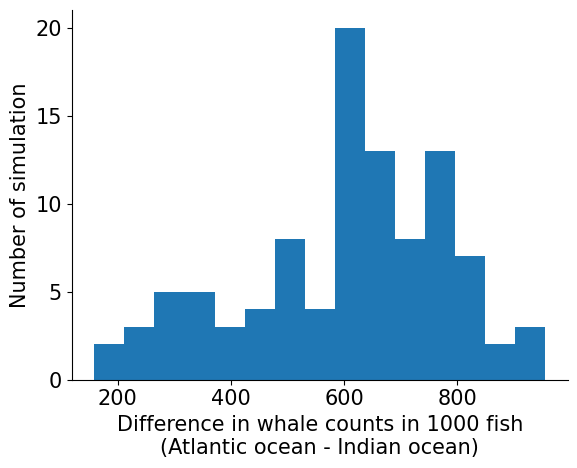

In [5]:
preditive = Predictive(model, num_samples=100)  # sample 100
pred = preditive(
    rng_key,
    whales_in_atlantic_ocean=whales_in_atlantic_ocean,
    sharks_in_atlantic_ocean=sharks_in_atlantic_ocean,
    whales_in_indian_ocean=whales_in_indian_ocean,
    sharks_in_indian_ocean=sharks_in_indian_ocean,
    n_samples=n_samples,
)
diff = pred["diff"]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(diff, bins=15)
ax.set_xlabel(
    "Difference in whale counts in 1000 fish\n(Atlantic ocean - Indian ocean)"
)
ax.set_ylabel("Number of simulation")
sns.despine()

In [6]:
interval = 0.90
lower_bound, upper_bound = hpdi(diff, prob=interval)
print(
    f"There's a {interval*100}% chance there are"
    f" {100*lower_bound/n_samples}% - {100*upper_bound/n_samples}% more whales in Atlantic oceans"
)

There's a 90.0% chance there are 27.9% - 85.0% more whales in Atlantic oceans


## Regression ##

We can also use the `numpyro` framework to fit regression lines. Let's simulate some data for a linear regression:

$$ y = \alpha + \beta x + \epsilon  $$

In [7]:
np.random.seed(1)
sample_size = 100  # number of data points
n_features = 3
x = np.random.random_sample((sample_size, n_features)) * 10 - 5  # random variable
alpha = np.random.random(1)[0] * 10  # intercept
beta = np.random.random_integers(low=1, high=10, size=x.shape[1]) + np.random.normal(
    loc=0, scale=1, size=x.shape[1]
)  # slope
epsilon = np.random.normal(
    loc=0, scale=1, size=sample_size
)  # adding some noise to the data
y = alpha + x @ beta + epsilon  # this is the dependent variable
print(f"Simulated beta: {beta}, alpha: {alpha:0.2}")

Simulated beta: [8.09719626 1.63659436 0.94350658], alpha: 8.1


we can fit it with scikit-learn and see if it can identified the parameters:

In [8]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(x, y)
sklearn_fitted_beta = lr.coef_
sklearn_fitted_alpha = lr.intercept_
sklearn_predicted = sklearn_fitted_alpha + x @ sklearn_fitted_beta
fmt_string = f"Sklearn: alpha = {sklearn_fitted_alpha:.2}"
for i, beta in enumerate(sklearn_fitted_beta):
    fmt_string += f"; beta{i+1}={sklearn_fitted_beta[i]:.2}"
print(fmt_string)

Sklearn: alpha = 8.1; beta1=8.1; beta2=1.6; beta3=0.95


In [9]:
y.shape

(100,)

In [10]:
def numpyro_linear_model(x: jnp.array, y: jnp.array) -> None:
    """
    a linear model with numpyro
    
    :param jnp.array x: explanatory variable, must be 2 dimension
    :param jnp.array y: response variable
    """
    if len(x.shape) != 2:
        raise ValueError("Input x must be two dimensions")
    
    if len(y.shape) != 1:
        raise ValueError("Input y must be single dimension")

    # initializing with very weak prior
    beta = numpyro.sample(
        "beta", dist.Normal(0, 100), sample_shape=(x.shape[1],)
    )  # very weak prior for our slopes
    intercept = numpyro.sample("intercept", dist.Normal(0, 100)) # weak prior for intercept
    error = numpyro.sample("error", dist.Exponential(0.1)) # noise term

    # fitting with the observation (the given response varaible)
    pred = jnp.dot(x, beta) + intercept
    numpyro.sample("pred", dist.Normal(pred, error), obs=y)

In [11]:
nuts_kernel = NUTS(numpyro_linear_model)
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=200, num_chains=1)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, x, y)

numpyro_fitted_beta = mcmc.get_samples()["beta"].mean(axis=0)
numpyro_fitted_alpha = mcmc.get_samples()["intercept"].mean()
numpyro_predicted = numpyro_fitted_alpha + x @ mcmc.get_samples()["beta"].mean(axis=0)
fmt_string = f"numpyro: alpha = {numpyro_fitted_alpha:.2}"
for i, beta in enumerate(sklearn_fitted_beta):
    fmt_string += f"; beta{i+1}={numpyro_fitted_beta[i]:.2}"
print(fmt_string)

sample: 100%|██████████| 1200/1200 [00:04<00:00, 278.47it/s, 3 steps of size 6.59e-01. acc. prob=0.93]


numpyro: alpha = 8.1; beta1=8.1; beta2=1.6; beta3=0.95


# Regression for group comparison (t-test) #

[t-tests are lienar models](https://lindeloev.github.io/tests-as-linear/), statistical tests can be represented as linear models. For example a two group t-tests can be viewed as:

![](https://lindeloev.github.io/tests-as-linear/index_files/figure-html/unnamed-chunk-27-1.png)

In such a case, the slope parameter ($\beta_1$) is t-tested against the null hypthesis $H_0: \beta_1 = 0$ (in `statsmodel`, not in `scikit-learn`) to assign a p-value to whether the difference between the groups is "significant".

We can do a simulated example with two groups:

In [12]:
n_samples = 10  # how many samples to simulate for each group
group1_mean = 10  # the mean for group 1
group2_mean = 8  # the mean for group 2
group1_samples = dist.Normal(loc=group1_mean, scale=3).sample(
    rng_key, sample_shape=(n_samples,)
)  # randomly sampling from a gaussian distribution
group2_samples = dist.Normal(loc=group2_mean, scale=1).sample(
    rng_key, sample_shape=(n_samples,)
)  # randomly sampling from a gaussian distribution

For most of the biology classes, we are often taught to use t-test:

In [13]:
from scipy.stats import ttest_ind

ttest_ind(group1_samples, group2_samples, alternative="two-sided")

Ttest_indResult(statistic=3.2545085612396165, pvalue=0.004401470375732842)

which gives a p-value of 0.0044

Let's see if we can derive the same from a linear regresssion:

In [14]:
import statsmodels.api as sm

x = np.append(jnp.zeros(n_samples), jnp.ones(n_samples)).reshape(-1, 1)
y = np.append(group1_samples, group2_samples)
sm_x = sm.add_constant(x)
mod = sm.OLS(y, sm_x)
fit = mod.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     10.59
Date:                Wed, 19 Oct 2022   Prob (F-statistic):            0.00440
Time:                        19:13:20   Log-Likelihood:                -30.235
No. Observations:                  20   AIC:                             64.47
Df Residuals:                      18   BIC:                             66.46
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.5251      0.366     26.042      0.000       8.757      10.294
x1            -1.6834      0.517     -3.255      0.004      -2.770      -0.597
==============================================================================
Omnibus:                        3.505   Durbin-Watson:                   1.539
Prob(Omnibus):                  0.173   Jarque-Bera (JB):                2.011
Skew:                           0.764   Prob(JB):                        0.366
Kurtosis:                       3.284   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From the second table from the top, we can see that parameter x1 (out slope) was assigned with a $P>|t|$ of 0.004, which matches what we saw from the `scipy.stats.ttest_ind`.

Now, what if we do the same but fit the linear regression with the above `numpyro` model:

In [15]:
nuts_kernel = NUTS(numpyro_linear_model)
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=200, num_chains=1)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, x, y)

sample: 100%|██████████| 1200/1200 [00:03<00:00, 325.54it/s, 7 steps of size 4.34e-01. acc. prob=0.95]


Using the numpyro framework, we can sample from the posterior distribution of $\beta$ for free, meaning we can look at the difference between the two sample groups as a distribution. The good news is, we don't have to rely on a binary cutoff of p-value (often 0.05, see: [Everything You Know about the P-Value is Wrong
](https://www.tldrpharmacy.com/content/everything-you-know-about-the-p-value-is-wrong), and this [talk](https://speakerdeck.com/pycon2016/jake-vanderplas-statistics-for-hackers?slide=47)). From the posterior distribution, we can pick 1. the effect size (how much differences), and 2. the probabilty of seeing this difference. And we can determine what threshold is "significant":

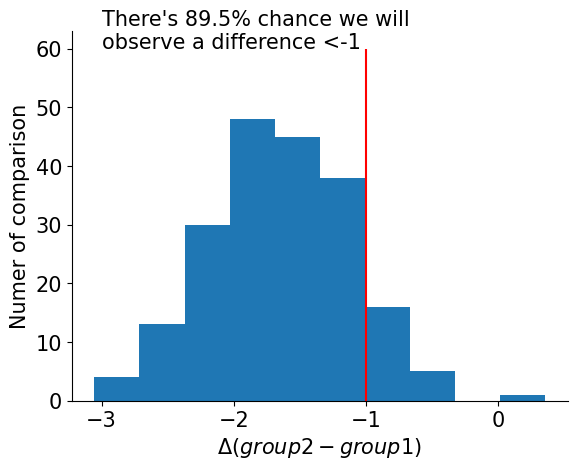

In [16]:
threshold = -1
diff = mcmc.get_samples()["beta"]
prob = len(diff[diff < threshold]) / len(diff)

fig = plt.figure()
ax = fig.add_subplot()
ax.hist(diff.reshape(-1), bins=10)
ax.vlines(x=threshold, ymin=0, ymax=60, color="red")
ax.text(
    -3,
    60,
    f"There's {prob*100}% chance we will\nobserve a difference <{threshold}",
    ha="left",
    fontsize=15
)
ax.set_xlabel(r'$\Delta (group2-group1)$')
ax.set_ylabel('Numer of comparison')
sns.despine()
ax.legend().set_visible(False)